<a href="https://colab.research.google.com/github/shruthimohan03/video-summarizer/blob/main/Final_GMM_with_SBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the dependencies

In [29]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# FINAL - NPTEL PYTHON VIDEO TEXT SUMMARIZATION

### 1. Import the preprocessed transcript

In [30]:
with open('/content/nptel_python_transcript_preprocessed.txt','r') as file:
  text=file.read()

### 2. Split the transcript to sentences using NLTK

In [31]:
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(text)

### 3. Embed the sentences using SBERT

In [32]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = model.encode(sentences, convert_to_tensor=False)

### 4. Using BIC to find the optimal number of clusters

#### Smart Thresholding depending on the number of sentences present in the transcript

In [33]:
import math

def get_cluster_range_percent(N, min_ratio=0.05, max_ratio=0.2):
    min_c = max(3, math.ceil(N * min_ratio))
    max_c = min(N - 1, math.ceil(N * max_ratio))
    return (min_c, max_c)

#### Range of clusters for trial and error

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Range of clusters to try
N = len(sentences)
clusters=get_cluster_range_percent(N)
n_components = np.arange(clusters[0],clusters[1]+1)
bics = []

#### Gaussian Mixture Model is fixed for all the cluster sizes and BIC is calculated

In [35]:
from sklearn.mixture import GaussianMixture

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(sentence_embeddings)
    bics.append(gmm.bic(sentence_embeddings))

#### Plotting the BIC values

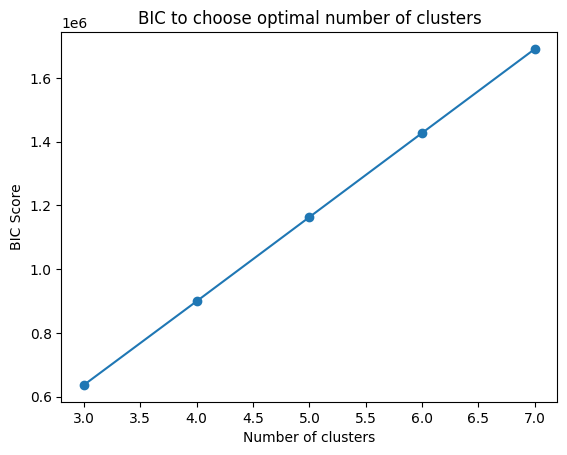

In [36]:
plt.plot(n_components, bics, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.title('BIC to choose optimal number of clusters')
plt.show()

#### Finding the most optimal no of clusters

In [37]:
optimal_clusters = n_components[np.argmin(bics)]
print("Optimal number of clusters:", optimal_clusters)

Optimal number of clusters: 3


### 5. Fit GMM using the optimal number of clusters

In [38]:
best_gmm = GaussianMixture(n_components=optimal_clusters, covariance_type='full', random_state=42)
best_gmm.fit(sentence_embeddings)

# Predict cluster labels
labels = best_gmm.predict(sentence_embeddings)

### 6. Extract one representative sentence per cluster (summary)

In [39]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from math import ceil

summary_sentences = []
seen_indices = set()

# You can tune this ratio
summary_ratio = 0.2
min_sentences_per_cluster = 1
max_sentences_per_cluster = 3

for cluster_idx in range(optimal_clusters):
    cluster_indices = np.where(labels == cluster_idx)[0]
    cluster_size = len(cluster_indices)

    # Skip clusters with only one sentence (likely noise)
    if cluster_size <= 1:
        continue

    cluster_embeddings = np.array([sentence_embeddings[i] for i in cluster_indices])
    cluster_sentences = [sentences[i] for i in cluster_indices]

    # Get centroid of the cluster
    centroid = best_gmm.means_[cluster_idx].reshape(1, -1)

    # Rank all cluster sentences by similarity to centroid
    similarities = cosine_similarity(centroid, cluster_embeddings)[0]
    sorted_idx = np.argsort(similarities)[::-1]  # Descending order

    # Determine how many sentences to extract from this cluster
    num_to_select = min(
        max(min_sentences_per_cluster, ceil(summary_ratio * cluster_size)),
        max_sentences_per_cluster
    )

    selected_indices = sorted_idx[:num_to_select]

    for idx in selected_indices:
        global_idx = cluster_indices[idx]
        if global_idx not in seen_indices:
            summary_sentences.append((global_idx, sentences[global_idx]))
            seen_indices.add(global_idx)

# Sort by original sentence order for coherence
summary_sentences = sorted(summary_sentences, key=lambda x: x[0])

# Final summary
summary = " ".join([s[1] for s in summary_sentences])

# Print summary
for _, sent in summary_sentences:
    print(sent)

So in this first introductory lecture I am just going to talk about why are we looking at Python for data science.
So to look at that first we are going to look at what data science is.
Data science is basically the science of analyzing raw data and deriving insights from this data.
Nonetheless the key focus of data science is in actually deriving these insights using whatever techniques that you want to use.
So when we talk about decisions the decisions could be across multiple verticals in an industry and data science is not only useful from an industrial perspective it is also useful in actual sciences themselves so where you look at lots of data to model your system or test your hypotheses or theories about systems and so on.
So with this I will stop this brief introduction on why python for data science.
I hope I have given you an idea of the fact that while we are going to teach you python as a programming language please keep in mind that each module that we teach in this is act

### Looking into the clusters

In [20]:
from collections import defaultdict

# Group sentences by their assigned topic
clustered_sentences = defaultdict(list)
for i, label in enumerate(labels):
    clustered_sentences[label].append(sentences[i])

# Print topics and their sentences
for topic, sentences in clustered_sentences.items():
    print(f"\n🟢 Topic {topic}:")
    for s in sentences:
        print(f"  - {s}")


🟢 Topic 1:
  -  Welcome to this course on Python for Data Science.
  - This is a 4-week course where we are going to teach you some very basic programming aspects in Python.
  - So in this first introductory lecture I am just going to talk about why are we looking at Python for data science.
  - Now why python for doing all of this the number one reason is that there are these python libraries which already are geared towards doing many of the things that we talked about so that it becomes easy for one to program and very quickly you can get some interesting outcomes out of what we are trying to do so there are as we talked about in the previous slide you need to do data manipulation and preprocessing there are lots of functions libraries in python where you can do data wrangling manipulation and so on.
  - The next step we talked about visualization there are libraries in python which can be used to do the visualization and finally for the more sophisticated analysis that we talked a

### Load and Preprocess Transcript from a TXT File

changing the code to include preprocessing of transcripts

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# Download required NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Define phrases to remove (extended list)
REMOVE_PHRASES = [
    r'\b[Ii] repeat\b',
    r'\buh\b', r'\bum\b', r'\bhmm\b', r'\buhh\b', r'\bmmm\b',
    r'\bokay\b', r'\bOkay\b', r'\bOK\b', r'\bok\b',
    r'\bso\b', r'\bSo,\b',
    r'\byou know\b', r'\blike\b', r'\bbasically\b',
    r'\bactually\b', r'\bkind of\b', r'\bsort of\b',
    r'\bat the end of the day\b', r'\bwell\b', r'\bright\b',
    r'\bjust\b', r'\bnow\b', r'\bthen\b',
    r'\bin particular\b', r'\bin general\b',
    r'\bI mean\b', r'\blet\'s see\b', r'\bas I said\b',
    r'\bremember\b', r'\bto be honest\b', r'\bI suppose\b',
    r'\bin fact\b', r'\bI think\b', r'\bfor example\b',
    r'\bin this particular\b', r'\bfor instance\b',
    r'\bas you know\b', r'\bas you can see\b',
    r'\blet me just\b', r'\bI\'ll just\b',
    r'\bif you think about it\b', r'\bas we discussed\b',
    r'\bsuppose\b', r'\bby that I mean\b',
    r'\bspecifically\b', r'\bbriefly\b',
    r'\bas you have seen\b', r'\bas we have discussed\b',
    r'\bas I have mentioned\b',
    r'\bnow coming back to\b', r'\bnow, coming back to\b',
    r'\btoday in this lecture\b', r'\bin this lecture\b',
    r'\bas the name would suggest\b', r'\bremember the name\b',
    r'\bthat is\b', r'\bthat means\b',
    r'\bas I was saying\b', r'\bas we were discussing\b'
]

REMOVE_REGEX = re.compile('|'.join(REMOVE_PHRASES))

def load_transcript(file_path):
    """Load and preprocess a transcript from a text file."""
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()
        return preprocess_transcript(text)

def preprocess_transcript(text):
    """Apply comprehensive preprocessing to transcript text."""
    # Convert to lowercase (optional, depending on requirements)
    text = text.lower()

    # Remove filler phrases
    text = REMOVE_REGEX.sub('', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Fix common transcription issues
    text = fix_transcription_errors(text)

    # Normalize punctuation
    text = normalize_punctuation(text)

    # Split into sentences (using NLTK for better segmentation)
    sentences = sent_tokenize(text)

    # Optional: Remove short sentences (likely fragments)
    sentences = [s for s in sentences if len(s.split()) > 3]

    return sentences

def fix_transcription_errors(text):
    """Fix common transcription errors."""
    # Fix repeated words (e.g., "the the")
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)

    # Fix common ASR errors
    replacements = {
        'Sanda': 'Sandhi',
        'Sunday operation': 'Sandhi operation',
        'GIFs law': 'Zipf\'s law',
        'GIF\'s law': 'Zipf\'s law',
        'Heaps law': 'Heaps\' law',
        'Giph law': 'Zipf\'s law',
        'Tokenarage': 'Tokenizer',
        'tokenarize': 'tokenize',
        'lamtaization': 'lemmatization',
        'lamtization': 'lemmatization',
        'perqueous': 'previous',
        'griddle': 'greedy',
        'Eglidi': 'greedy',
        'on the relation': 'sandhi relation',
        'portus algorithm': 'Porter\'s algorithm',
        'clean it': 'kleene',
        'affix is': 'affixes',
        'prefossessing': 'preprocessing',
        'infix': 'infix',
        'perqueous': 'previous',
        'coppers': 'corpus'
    }

    for old, new in replacements.items():
        text = re.sub(r'\b' + re.escape(old) + r'\b', new, text)

    return text

def normalize_punctuation(text):
    """Standardize punctuation in transcript."""
    # Fix spacing around punctuation
    #text = re.sub(r'\s+([.,;:!?])', r'\1', text)

    # Standardize quotes
    text = re.sub(r'["""]', '"', text)
    text = re.sub(r"['\']", "'", text)

    # Fix ellipses
    text = re.sub(r'\.\.\.', '…', text)

    # Fix dashes
    text = re.sub(r'--', '—', text)

    return text

def remove_stopwords(sentences, exclude_list=None):
    """Remove stopwords from sentences."""
    stop_words = set(stopwords.words('english'))
    if exclude_list:
        stop_words = stop_words - set(exclude_list)

    result = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        result.append(' '.join(filtered_words))

    return result

def stem_sentences(sentences):
    """Apply Porter stemming to sentences."""
    stemmer = PorterStemmer()
    result = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        stemmed_words = [stemmer.stem(word) for word in words]
        result.append(' '.join(stemmed_words))

    return result

def lemmatize_sentences(sentences):
    """Apply lemmatization to sentences."""
    lemmatizer = WordNetLemmatizer()
    result = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        result.append(' '.join(lemmatized_words))

    return result

# Example usage
if __name__ == "__main__":
    file_path = "/content/transcribed_text_nptel_video_1.txt"

    # Basic preprocessing
    sentences = load_transcript(file_path)
    print(f"Number of sentences after basic preprocessing: {len(sentences)}")

    # Optional: Further processing based on needs
    # sentences_without_stopwords = remove_stopwords(sentences)
    # lemmatized_sentences = lemmatize_sentences(sentences)
    # stemmed_sentences = stem_sentences(sentences)

    # Print first few sentences
    for i, sentence in enumerate(sentences[:15]):
        print(f"Sentence {i+1}: {sentence}")

Number of sentences after basic preprocessing: 323
Sentence 1: hello everyone, welcome back to the final lecture of the first week.
Sentence 2: , in the last lecture we were discussing about various empirical laws.
Sentence 3: , , gifs law and heaps law that how the words in the vocabulary are distributed in a corpus.
Sentence 4: and we saw that the distribution is not very uniform.
Sentence 5: there are certain words that are very, very common.
Sentence 6: , we saw that roughly 100 words in the vocabulary make for 50 percent of the corpus, but by that i mean that number of tokens.
Sentence 7: and on the other hand, there are 50 percent of the words in the vocabulary that occur only once.
Sentence 8: and we discussed what are the various relationships among the vocabulary size and the number of tokens that i observe in a corpus.
Sentence 9: and also how they grow with us to each other.
Sentence 10: and gifs law gives gave me a relation between the frequency and the rank of a word.
Sent

### Preprocess and Convert Sentences into BERT Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

# Load SBERT model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Convert transcript sentences to embeddings
def get_sentence_embeddings(sentences):
    return model.encode(sentences, convert_to_numpy=True)

# Generate embeddings
sentence_vectors = get_sentence_embeddings(sentences)


### Apply Gaussian Mixture Model (GMM) for Clustering

In [ ]:
from sklearn.mixture import GaussianMixture

# Choose the number of clusters based on BIC/AIC
num_clusters = 6

# Fit GMM
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(sentence_vectors)

# Predict cluster labels
labels = gmm.predict(sentence_vectors)


### Group Sentences by Cluster

In [ ]:
from collections import defaultdict

# Group sentences by their assigned topic
clustered_sentences = defaultdict(list)
for i, label in enumerate(labels):
    clustered_sentences[label].append(sentences[i])

# Print topics and their sentences
for topic, sentences in clustered_sentences.items():
    print(f"\n🟢 Topic {topic}:")
    for s in sentences:
        print(f"  - {s}")



🟢 Topic 0:
  - hello everyone, welcome back to the final lecture of the first week.
  - , in the last lecture we were discussing about various empirical laws.
  - and we saw that the distribution is not very uniform.
  - and also how they grow with us to each other.
  - , we will cover the basic concepts and what are the challenges that one might face while doing the processing.
  - , this you may or may not have to do always and it depends on what is your application.
  - , , you are doing classification for the whole document into certain classage.
  - , you might feel that this is very trivial task, but let us see is it trivial.
  - , do you think there might be certain challenge involved?
  - , again you have numbers 2.44.3 and on.
  - , in text processing, if we face this problem in nearly every simple task that we are doing.
  - , how do we go about solving this.
  - , any data point that i am seeing, i have to divide into one of these two classes.
  - , each point you have to d

### Extract Keywords for Each Cluster

To get topic keywords, use TF-IDF on sentences inside each cluster.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get keywords for each topic
def get_top_keywords(sentences, num_words=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentences)
    feature_array = vectorizer.get_feature_names_out()
    tfidf_sorting = X.sum(axis=0).A1.argsort()[::-1]
    return [feature_array[i] for i in tfidf_sorting[:num_words]]

# Print top words per topic
for topic, sentences in clustered_sentences.items():
    keywords = get_top_keywords(sentences)
    print(f"\n🔹 Topic {topic} Keywords: {keywords}")



🔹 Topic 0 Keywords: ['simple', 'problem', 'help', 'step', 'used']

🔹 Topic 2 Keywords: ['features', 'classes', 'examples', 'use', 'general']

🔹 Topic 3 Keywords: ['word', 'words', 'sanskrit', 'sentence', 'problem']

🔹 Topic 1 Keywords: ['sentence', 'tokens', 'problem', 'tokenization', 'words']

🔹 Topic 4 Keywords: ['case', 'uppercase', 'language', 'problem', 'lowercase']

🔹 Topic 5 Keywords: ['sentence', 'end', 'word', 'dot', 'say']


Looks like clustering happened based on: Tokenization, Stopword/word/lemmatization, importance, NER, POS

### SUMMARIZE by picking the most important sentence in each cluster

In [ ]:
!pip install sympy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cud

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extractive_summary(sentences,topic):
    # Embed all the sentences in each cluster using SBERT
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(sentences)

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    # Find the most central sentence (highest avg similarity)
    avg_sim = np.mean(similarity_matrix, axis=1)
    central_idx = np.argmax(avg_sim) # np.argmax gives the index of the max value

    selected_indices = [central_idx] # storing the selected sentences' indices
    #print(sentences[central_idx],max(avg_sim))

    if topic==0:
        similarity_matrix[:, selected_indices[-1]] = -1
        similarity_matrix[selected_indices[-1], :] = -1
        avg_sim = np.mean(similarity_matrix, axis=1)
        central_idx = np.argmax(avg_sim)
        selected_indices.append(central_idx)
    return ''.join([sentences[i] for i in selected_indices])

In [ ]:
summary=''
for topic, sentences in clustered_sentences.items():
    summary = extractive_summary(sentences,topic)
    print(f"{summary}")

So, this looks again a simple problem but we will see it is not that simple.So, this problem is related.
So, we will start with the example of a simple decision tree.
In English in general we do not combine words to make a single word.
So, now before going into what is tokenization, I will just talk about a slightly related problem sentence segmentation.
And this is important for the application of machine translation also because if you do a case folding here, you will know u s in lower case that means something else was such u s that is in United States.
So, now for each dot or in general for every word, I need to decide whether this is the end of the sentence or not the end of the sentence.
